In [1]:
import numpy as np
import pandas as pd

/usr/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Объявление констант с неизменной информацией о загружаемых данных

In [2]:
URL_TO_TRAIN_DATA = r"http://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data"
URL_TO_TEST_DATA = r"http://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data"

indexes = []
for index in range(1, 6):
    indexes.append(index)
    indexes.append(index)

COLUMNS_NAMES = [
    (letter + str(index)).lower() for letter, index in zip(
        ["S", "C"] * 5,
        indexes
    )
] + ["class"]

Загрузка данных обучающей выборки средствами *Pandas*, вывод первых 5 строк таблицы на экран.

In [3]:
data_train = pd.read_csv(
    URL_TO_TRAIN_DATA,
    header=None,
    names=COLUMNS_NAMES,
    dtype={column_name: "object" for column_name in COLUMNS_NAMES}
)
data_train.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


Загрузка данных тестовой выборки средствами *Pandas*, вывод первых 5 строк таблицы на экран.

In [4]:
data_test = pd.read_csv(
    URL_TO_TEST_DATA,
    header=None,
    names=COLUMNS_NAMES,
    dtype={column_name: "object" for column_name in COLUMNS_NAMES}
)
data_train.head()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9



Выводим базовую статистическую информацию по обучающей выборке. Поскольку мы знаем значения, которые будет принимать каждый из признаков, они являются дискретными и строго ограниченными, поэтому мы интерпретируем их как категориальные признаки.  
* *count* - количество объектов, имеющих данный признак (замечаем, что они везде равны, т.е. пропущенные значения отсутствуют),
* *unique* - количество уникальных значений признака,
* *top* - самое часто встречающееся значение признака (мода признака),
* *freq* - количество появлений значения, описанного в предыдущем пункте.

In [5]:
data_train.describe()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
count,25010,25010,25010,25010,25010,25010,25010,25010,25010,25010,25010
unique,4,13,4,13,4,13,4,13,4,13,10
top,4,1,1,13,4,10,3,3,3,8,0
freq,6312,1982,6309,2007,6419,2000,6314,1999,6314,1994,12493


Аналогичное действие проводим с тестовой выборкой.

In [6]:
data_test.describe()

,s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,class
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,4,13,4,13,4,13,4,13,4,13,10
top,3,6,1,11,3,7,3,7,1,3,0
freq,250900,77282,250362,77373,250748,77517,250600,77581,250755,77566,501209


Разделяем каждую из имеющихся выборок на две части:  
* *X* - часть, располагающая нецелевыми признаками, т.е. такими признаками, на основе которых будут происходить предсказания,
* *y* - часть, содержащая целевые признаки (в данном случае он один - *class*) - ответы, которые требуется предсказывать и прогнозировать,  

Методами *Pandas* производим описанное разделение и выводим размерности полученных массивов.

In [7]:
X_train, y_train = data_train.drop(["class"], axis=1), data_train["class"]
X_test, y_test = data_test.drop(["class"], axis=1), data_test["class"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25010, 10), (25010,), (1000000, 10), (1000000,))

Очевидно, что тестовая выборка имеет избыточное количество данных (их примерно в $40$ раз больше, чем обучающих), поэтому взять из них данные для проверки обучения нейронной сети (валидации) не составит труда, возьмем соотношение проверочных данных к тестовым $1:1$.  
Произведем разделение и выведем размерности полученных массивов на экран.

In [8]:
X_val, y_val = X_test[:X_test.shape[0] // 2], y_test[:y_test.shape[0] // 2]
X_test, y_test = X_test[X_test.shape[0] // 2:], y_test[y_test.shape[0] // 2:]

X_test.shape, y_test.shape, X_val.shape, y_val.shape

((500000, 10), (500000,), (500000, 10), (500000,))

Поскольку все наши признаки являются дискретными категориальными, их нужно векторизировать, делается это следующим образом:  
если имеется признак $\ f $, имеющий множество значений $\{v_1,\ v_2, \dots,\ v_n \},\ n \in \mathbb{N}$, тогда мы делим признак $\ f $ на множество признаков $\big\{f_{v_1},\ f_{v_2}, \dots,\ f_{v_n} \big\}$, каждый из которых принимает значения из множества $\{0, 1\}$, указывающих на принадлежность объекта данных тому или иному значению первоначального признака.  
Методами *Pandas* делаем такое преобразование данных и выводим размерности полученных массивов на экран. Замечаем, что $10$ нецелевых признаков преобразовались в $85$ бинарных числовых, а целевой признак *class* аналогично раздробился на $10$ признаков.

In [9]:
X_train, y_train = pd.get_dummies(X_train), pd.get_dummies(y_train, prefix=COLUMNS_NAMES[-1])
X_test, y_test = pd.get_dummies(X_test), pd.get_dummies(y_test, prefix=COLUMNS_NAMES[-1])
X_val, y_val = pd.get_dummies(X_val), pd.get_dummies(y_val, prefix=COLUMNS_NAMES[-1])

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((25010, 85),
 (25010, 10),
 (500000, 85),
 (500000, 10),
 (500000, 85),
 (500000, 10))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Методами *Keras* с back-end *TensorFlow* конструируем архитектуру нейронной сети.  
* *Sequential* - модель нейронной сети, в которой слои соединяются последовательно в строгом порядке,
* *Dense* - т.н. полносвязный слой, т.е. слой нейронной сети, в котором все нейроны текущего уровня соединяются со всеми нейронами следующего уровня,  

Архитектура такова:
1. Первый, входной слой: возьмем количество нейронов величиной, равной количеству векторизированных нецелевых признаков, т.е. $85$, количество входов так же равно количеству нецелевых признаков - $85$, веса и смещения генерируются случайно с нормальным распределением, функция активации - *SoftPlus*,
2. Второй, выходной слой: $10$ нейронов (или по-другому выходных сигналов), каждый из которых будет соответствовать вероятности принадлежности того или иного значения признака *class* обрабатываемому объетку, веса и смещения генерируются случайно с нормальным распределением, функция активации - *Sigmoid*.  

Компилируем модель с такими параметрами:
1. Функция потерь (*loss*) - категориальная перекрестная энтропия,
2. Оптимизатор параметров нейронной сети (*optimizer*) - Adam,
3. Метрики для оценки работы нейронной сети: точность (*accuracy*).

In [27]:
model = Sequential()

model.add(
    Dense(
        85, # number of neurons
        input_dim=X_train.shape[1], # number of inputs
        kernel_initializer="normal", # weights initialization (maybe: "zeros", "ones", ... -> https://keras.io/initializers/)
        activation="softplus" # activation function (smooth ReLU), maybe: "softmax", "relu", "tanh", ... -> https://keras.io/activations/
    )
)
model.add(
    Dense(
        10,
        kernel_initializer="normal",
        activation="sigmoid"
    )
)

model.compile(
    loss="categorical_crossentropy", # loss function (maybe: "categorical_hinge", ... -> https://keras.io/losses/)
    optimizer="adam", # parameters optimizer (maybe: "sgd", "adagrad", ... -> https://keras.io/optimizers/)
    metrics=["accuracy"] # metrics for evaluation (maybe: "categorical_accuracy", ... -> https://keras.io/metrics/)
)

global_losses_history = {
    "loss": [],
    "val_loss": []
}

Обучаем нейронную сеть на обучающей выборке (*X_train*, *y_train*), с размером мини-выборки, равным длине самой выборки, используем данные для проверки работы нейронной сети в ходе обучения (*X_val*, *y_val*).  
Из-за ограничений сервиса *PythonAnywhere* обучаем сеть в несколько заходов, по $1000$ эпох каждый.  
В конце каждого захода выводится длительность обучения в секундах.

In [43]:
from time import clock

start = clock()

fit_result = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=int(1 * X_train.shape[0]),
    verbose=2, # results printing: 0 - not to print, 1 - print every epoch learning and result, 2 - print every epoch only result
    validation_data=(
        X_val,
        y_val
    )
)

global_losses_history["loss"] += fit_result.history["loss"]
global_losses_history["val_loss"] += fit_result.history["val_loss"]

print("Training runtime:", clock() - start)

Train on 25010 samples, validate on 500000 samples
Epoch 1/1000
 - 5s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 2/1000
 - 2s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 3/1000
 - 2s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 4/1000
 - 1s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 5/1000
 - 2s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 6/1000
 - 2s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 7/1000
 - 3s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 8/1000
 - 2s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 9/1000
 - 1s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 10/1000
 - 1s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 11/1000
 - 2s - loss: 0.0717 - acc: 0.9772 - val_loss: 0.1596 - val_acc: 0.9622
Epoch 12/100

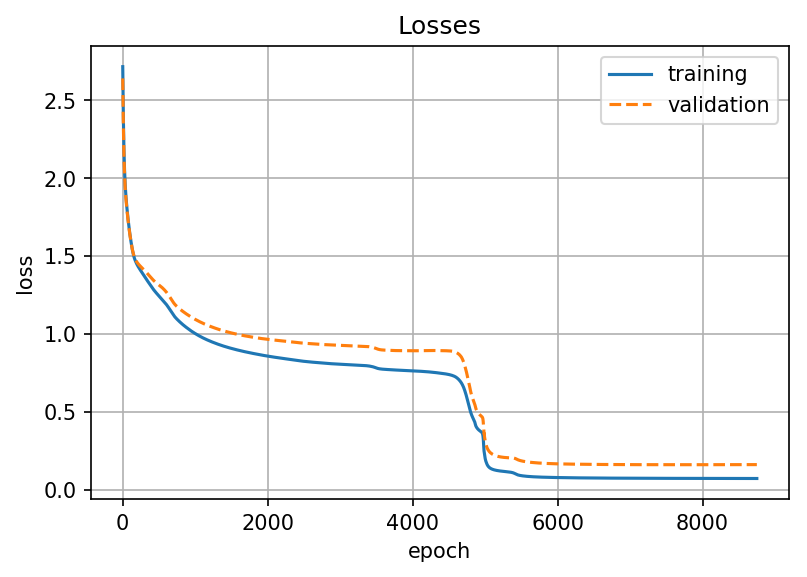

In [47]:
import matplotlib.pyplot as plt

plt.rcParams["savefig.dpi"] = 150

plt.plot(
    global_losses_history["loss"],
    label="training"
)
plt.plot(
    global_losses_history["val_loss"],
    "--",
    label="validation"
)

plt.xlabel("epoch")
plt.ylabel("loss")

plt.grid()
plt.title("Losses")
plt.legend()

plt.show()

In [46]:
json_of_model = model.to_json()

with open("pkr_model.json", "w") as json_file:
    json_file.write(json_of_model)

model.save_weights("pkr_weights.h5")

In [45]:
test_error = 1 - model.evaluate(X_test, y_test, verbose=0)[1]
test_error

0.03773199999999999